In [ ]:
pip install PyTDC

     |████████████████████████████████| 81kB 4.4MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.2.0-cp37-none-any.whl size=79517 sha256=b439eb4e85336e636b3a1a465f7446f85d311fc40e4458105e038c5f82813b3a
  Stored in directory: /root/.cache/pip/wheels/22/e6/c5/788aaa9016c28e869cd099ec737543a0a0731c27a24d8fe11a
Successfully built PyTDC


In [ ]:
!nvidia-smi -L


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
from sklearn import metrics
from sklearn import metrics
from sklearn.utils import shuffle

In [ ]:
from tdc.single_pred import ADME
data = ADME(name = 'Pgp_Broccatelli')
split = data.get_split()

Downloading...
100%|██████████| 126k/126k [00:00<00:00, 133kiB/s]
Loading...
Done!


In [ ]:
train = split['train']
valid = split['valid']
test = split['test']

In [ ]:
train = shuffle(train)

In [ ]:
Xtrain = train.iloc[:, 1].str.lower()
Ytrain = train.iloc[:, 2].values
Xvalid = valid.iloc[:, 1].str.lower()
Yvalid = valid.iloc[:, 2].values
Xtest = test.iloc[:, 1].str.lower()
Ytest = test.iloc[:, 2].values

In [ ]:
vocabulary = []
for i in Xtrain:
    for m in i:
        if m not in vocabulary:
            vocabulary.append(m)
for i in Xvalid:
    for m in i:
        if m not in vocabulary:
            vocabulary.append(m)
for i in Xtest:
    for m in i:
        if m not in vocabulary:
            vocabulary.append(m)

In [ ]:
indexer = {word: index for (index, word) \
in enumerate(vocabulary)}

In [ ]:
indexed_reviews = []
indexed_reviews2 = []
indexed_reviews3 = []
for review in Xtrain:
    indexed_reviews.append([indexer[word] \
    for word in review])
for review in Xvalid:
    indexed_reviews2.append([indexer[word] \
    for word in review])
for review in Xtest:
    indexed_reviews3.append([indexer[word] \
    for word in review])        

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, \
        hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, \
        n_layers, batch_first=True, bidirectional = True, dropout = 0.2)
        self.output = nn.Linear(hidden_size, 2)
    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.output(out)
        out = out[-1,0]
        out = torch.sigmoid(out).unsqueeze(0)
        return out

In [ ]:
loss_function = nn.BCELoss()
epochs = 50

In [ ]:
losses = []
acc = []
accv = []
auc = []
auc2 = []
validloss = []
validlosst = []
validcheck = []
learning_rate = [0.001 ,0.0001]
embed_size = [ 100, 150]
hidden_size = [100, 200]
num_layers = [2, 3]
for lr in learning_rate:
    for embed in  embed_size:
        for hidden in hidden_size:
            for layer in num_layers:
                model = LSTM(len(vocabulary), embed, hidden, layer )
                optimizer = optim.Adam(model.parameters(), lr=lr, amsgrad=True)
                for e in range(1, epochs+1):
                    single_loss = []
                    preds = []
                    targets = []
                    preds2 = []
                    targets2 = []
                    for i, r in enumerate(indexed_reviews):
                        if len(r) <= 1:
                            continue
                        x = torch.Tensor([r]).long()
                        y = torch.Tensor([Ytrain[i]])
                        pred = model(x)
                        loss = loss_function(pred, y)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        final_pred = np.round(pred.detach().numpy())
                        preds.append(final_pred)
                        targets.append(y)
                        single_loss.append(loss.item())
                    losses.append(np.mean(single_loss))
                    accuracy = accuracy_score(targets,preds)
                    acc.append(accuracy)
                    aucc = metrics.roc_auc_score(targets, preds)
                    auc.append(aucc)
                    if e%1 == 0:
                        print("Epoch: ", e, "... Loss function: ", losses[-1], \
                        "... Accuracy: ", acc[-1], "...AUC: ", auc[-1] )    
                    if e %1 ==0:
                        validlosst.clear()
                        validloss.clear()
                        with torch.no_grad():
                            for i, r in enumerate(indexed_reviews2):
                                xvalid = torch.Tensor([r]).long()
                                yvalid = torch.Tensor([Yvalid[i]])
                                predv = model(xvalid)
                                lossv = loss_function(predv, yvalid)
                                validloss.append(lossv.item())
                                final_predv = np.round(predv.detach().numpy())
                                preds2.append(final_predv)
                                targets2.append(yvalid) 
                            validlosst.append(np.mean(validloss))
                            validcheck.append(np.mean(validloss))
                            accuracy2 = accuracy_score(targets2,preds2)
                            accv.append(accuracy2)
                            auccv = metrics.roc_auc_score(targets2, preds2)
                            auc2.append(auccv)
                            print("epoch: ", e, "... AUCvalid: ", auc2[-1], "...ACCURACY: ", accv[-1], "...valid_loss: ", validlosst[-1])
                    if e >1:
                        if validcheck[-1] == min(validcheck):
                            torch.save(model, '/content/sample_data/best_model.pth')
                            best_lr = lr
                            best_layer = layer
                            best_embed = embed
                            best_hidden = hidden

print("best learning rate :", best_lr)
print("best hidden size: ", best_hidden)
print("best embedding size: ", best_embed)
print("best number of layers: ", best_layer)

In [ ]:
best_model = torch.load("/content/sample_data/best_model.pth")

In [ ]:
print("best learning rate :", best_lr)
print("best hidden size: ", best_hidden)
print("best embedding size: ", best_embed)
print("best number of layers: ", best_layer)

best learning rate : 0.001
best hidden size:  200
best embedding size:  100
best number of layers:  3


In [ ]:
best_model.eval()
targets3 = []
preds3 = []
acct = []
auc3 = []

with torch.no_grad():
    for i, r in enumerate(indexed_reviews3):
        x = torch.Tensor([r]).long()
        y = torch.Tensor([Ytest[i]])
        pred = best_model(x)
        final_pred = np.round(pred.detach().numpy())
        preds3.append(final_pred)
        targets3.append(y)      
    accuracy3 = accuracy_score(targets3,preds3)
    acct.append(accuracy3)
    auct = metrics.roc_auc_score(targets3, preds3)
    auc3.append(auct)
    print( "... AUCvalid: ", auc3, "...ACCURACY: ", acct)

... AUCvalid:  [0.8112611704629443] ...ACCURACY:  [0.8114754098360656]


In [ ]:
classification_report_= metrics.classification_report(targets3, preds3)

In [ ]:
print(classification_report_)

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81       121
         1.0       0.80      0.84      0.82       123

    accuracy                           0.81       244
   macro avg       0.81      0.81      0.81       244
weighted avg       0.81      0.81      0.81       244



In [ ]:
conf = metrics.confusion_matrix(targets3, preds3)

In [ ]:
import itertools

Text(0.5, 15.0, 'Predicted label')

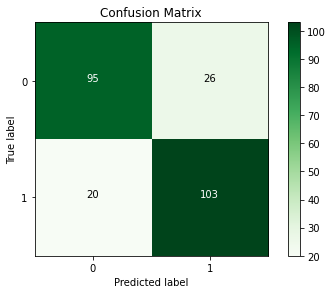

In [ ]:
classes = [0, 1]
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
rf_fpr, rf_tpr, _ = metrics.roc_curve(targets3, preds3)
r_probs = [0 for _ in range(len(targets3))]
r_auc = metrics.roc_auc_score(targets3, r_probs)
r_fpr, r_tpr, _ = metrics.roc_curve(targets3, r_probs)

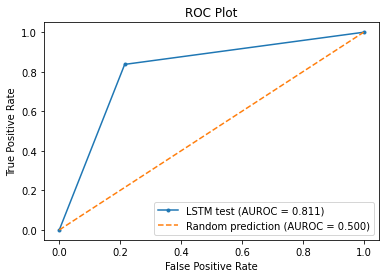

In [ ]:
plt.plot(rf_fpr, rf_tpr, marker='.', label='LSTM test (AUROC = %0.3f)' % auc3[0])
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)


plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() 
# Show plot
plt.show()